In [4]:
import os
from tqdm import tqdm # This allows you to wrap any iterable in python and it then creates a progress bar for you within jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import seaborn as sns

# python speech features is an audio library
from python_speech_features import mfcc, logfbank

# This is the common audio library
import librosa

In [5]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [6]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [7]:
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [8]:
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [9]:
# FFT has two parts (magnitude and frequency)
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate) # This goes to the x-axis with the spaces between the samples (d)
    Y = abs(np.fft.rfft(y)/n) # Generate the magnitude - This is the y-axis. Normalize the length of the signal by dividing by n
    return (Y, freq)

In [10]:
# Function to detect the estimation of the magnitude i.e. the Amplitude of the signal i.e. if the amplitude is too low
# then it can be stripped off since the audio has died out
# Basically to do Noise Forward Detection of the signal
def envelop(y,rate,threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10),min_periods=1,center=True).mean()
    
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
            
    return mask

In [11]:
# Get the current working directory
cwd = os.getcwd()

# Go one folder back
parent_dir = os.path.dirname(cwd)

# Specify the relative path to the audio file from the parent directory
relative_path = r"Dataset\Language-Recognition-VAD-MFCC\Tamil-Train.csv"

speech_df = pd.read_csv(os.path.join(parent_dir, relative_path))

In [12]:
speech_df.head(10)

,File Name,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
0,000020045.wav,-457.84314,185.44336,35.781960,-16.938108,-7.395579,-8.949813,-9.582459,5.201546,4.738354,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
1,000020045.wav,-428.55040,189.45868,17.123732,-12.962234,-0.573131,-2.881281,-8.458666,-0.055087,5.620351,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
2,000020045.wav,-367.49720,194.50418,-13.056679,-4.157114,-22.554285,-19.575530,-3.851059,-3.728880,4.788766,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
3,000020045.wav,-280.22574,208.56305,-31.201574,7.831125,-62.149563,-24.098580,7.857093,5.876415,9.197849,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
4,000020045.wav,-242.70015,202.11122,-51.431137,1.769407,-80.866165,-15.219257,14.262138,7.462859,5.481049,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
5,000020045.wav,-226.39484,209.24460,-71.618040,-19.899410,-88.173840,-20.188892,12.333050,2.696269,1.909176,...,1.693372,7.446925,2.981990,-2.899798,-1.199813,-0.101917,1.733266,0.636342,0.204555,-1.421537
6,000020045.wav,-214.96146,221.23523,-92.501175,-30.524715,-73.999480,-26.600723,10.607412,0.847954,-3.396488,...,4.070578,5.156596,3.121057,-3.835257,-0.691226,-0.749398,1.983619,0.759084,0.392523,0.455498
7,000020045.wav,-198.61263,212.37476,-108.856384,-28.056328,-60.217667,-17.189074,6.662716,6.101118,-3.660522,...,6.351392,2.224033,3.241744,-2.764134,1.764480,-0.760435,1.482908,0.078964,-0.852306,2.280504
8,000020045.wav,-183.21855,199.46605,-110.657196,-6.391638,-52.204110,-4.010246,3.711313,-1.544158,-0.791210,...,5.210469,-0.106006,2.378655,-0.842220,2.802527,-0.451843,0.869382,-0.897387,-1.120428,2.968668
9,000020045.wav,-188.94430,191.05524,-87.845580,6.088990,-49.831955,6.372743,-11.295851,-8.029653,-4.089959,...,2.008737,-1.230489,-0.283200,0.567051,2.301227,0.180660,-0.309392,-1.831700,-1.056957,2.595908


In [ ]:
# speech_df = speech_df.iloc[:][1:13]
# speech_df = speech_df.iloc[: ,1:14]

In [13]:
speech_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54525 entries, 0 to 54524
Data columns (total 40 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   File Name   54525 non-null  object 
 1   Feature_1   54525 non-null  float64
 2   Feature_2   54525 non-null  float64
 3   Feature_3   54525 non-null  float64
 4   Feature_4   54525 non-null  float64
 5   Feature_5   54525 non-null  float64
 6   Feature_6   54525 non-null  float64
 7   Feature_7   54525 non-null  float64
 8   Feature_8   54525 non-null  float64
 9   Feature_9   54525 non-null  float64
 10  Feature_10  54525 non-null  float64
 11  Feature_11  54525 non-null  float64
 12  Feature_12  54525 non-null  float64
 13  Feature_13  54525 non-null  float64
 14  Feature_14  54525 non-null  float64
 15  Feature_15  54525 non-null  float64
 16  Feature_16  54525 non-null  float64
 17  Feature_17  54525 non-null  float64
 18  Feature_18  54525 non-null  float64
 19  Feature_19  54525 non-nul

In [14]:
speech_df.nunique()

File Name       240
Feature_1     54372
Feature_2     54333
Feature_3     54502
Feature_4     54479
Feature_5     54493
Feature_6     54498
Feature_7     54496
Feature_8     54497
Feature_9     54504
Feature_10    54487
Feature_11    54500
Feature_12    54502
Feature_13    54479
Feature_14    52587
Feature_15    52581
Feature_16    52585
Feature_17    52593
Feature_18    52587
Feature_19    52587
Feature_20    52593
Feature_21    52592
Feature_22    52587
Feature_23    52591
Feature_24    52587
Feature_25    52593
Feature_26    52596
Feature_27    52586
Feature_28    52596
Feature_29    52577
Feature_30    52587
Feature_31    52585
Feature_32    52590
Feature_33    52592
Feature_34    52589
Feature_35    52574
Feature_36    52594
Feature_37    52580
Feature_38    52590
Feature_39    52580
dtype: int64

In [15]:
speech_df.describe()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
count,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,...,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000,54525.000000
mean,-337.412772,138.129434,-16.040022,34.372182,-15.340156,-3.547533,-6.096901,-8.389714,-5.278412,-10.493790,...,-0.002133,0.040107,0.018716,-0.001151,0.013867,0.004514,0.005444,0.001924,0.002503,0.001789
std,110.465185,43.463792,36.003567,31.292846,26.125894,17.539660,17.148404,15.500237,11.688326,14.295757,...,3.030579,3.076285,1.958789,1.757686,1.872998,1.379596,1.643602,1.369734,1.246720,1.382823
min,-677.302060,-12.806042,-128.872010,-63.075645,-108.525240,-66.734764,-58.324886,-70.912600,-59.214573,-64.814354,...,-13.558767,-10.826191,-9.464654,-6.908466,-9.212391,-5.841762,-6.168666,-5.339757,-5.404377,-5.240837
25%,-401.759980,114.355390,-42.853540,11.393013,-33.449318,-15.877722,-19.158188,-19.197190,-12.488392,-20.737446,...,-1.823376,-2.061758,-1.199756,-1.164641,-1.166278,-0.877666,-1.073748,-0.881900,-0.794717,-0.865707
50%,-309.207150,145.088100,-16.758873,30.931664,-13.047951,-4.467809,-5.544406,-8.046988,-4.219844,-10.082497,...,0.053778,-0.051355,0.040031,-0.005182,0.017978,-0.034867,-0.010369,-0.013098,0.000449,0.023459
75%,-255.696090,169.937470,10.558662,55.584550,4.479470,7.802557,6.605959,2.622869,3.047964,0.384408,...,1.894546,2.053809,1.269367,1.146994,1.212351,0.826178,1.074516,0.864534,0.806810,0.894946
max,-85.578340,246.222870,97.081924,139.049510,54.170990,72.646510,50.943905,51.256300,38.519547,32.598470,...,14.314651,11.775063,9.397688,7.197719,8.326958,6.294942,8.062936,5.666927,5.466359,6.101533


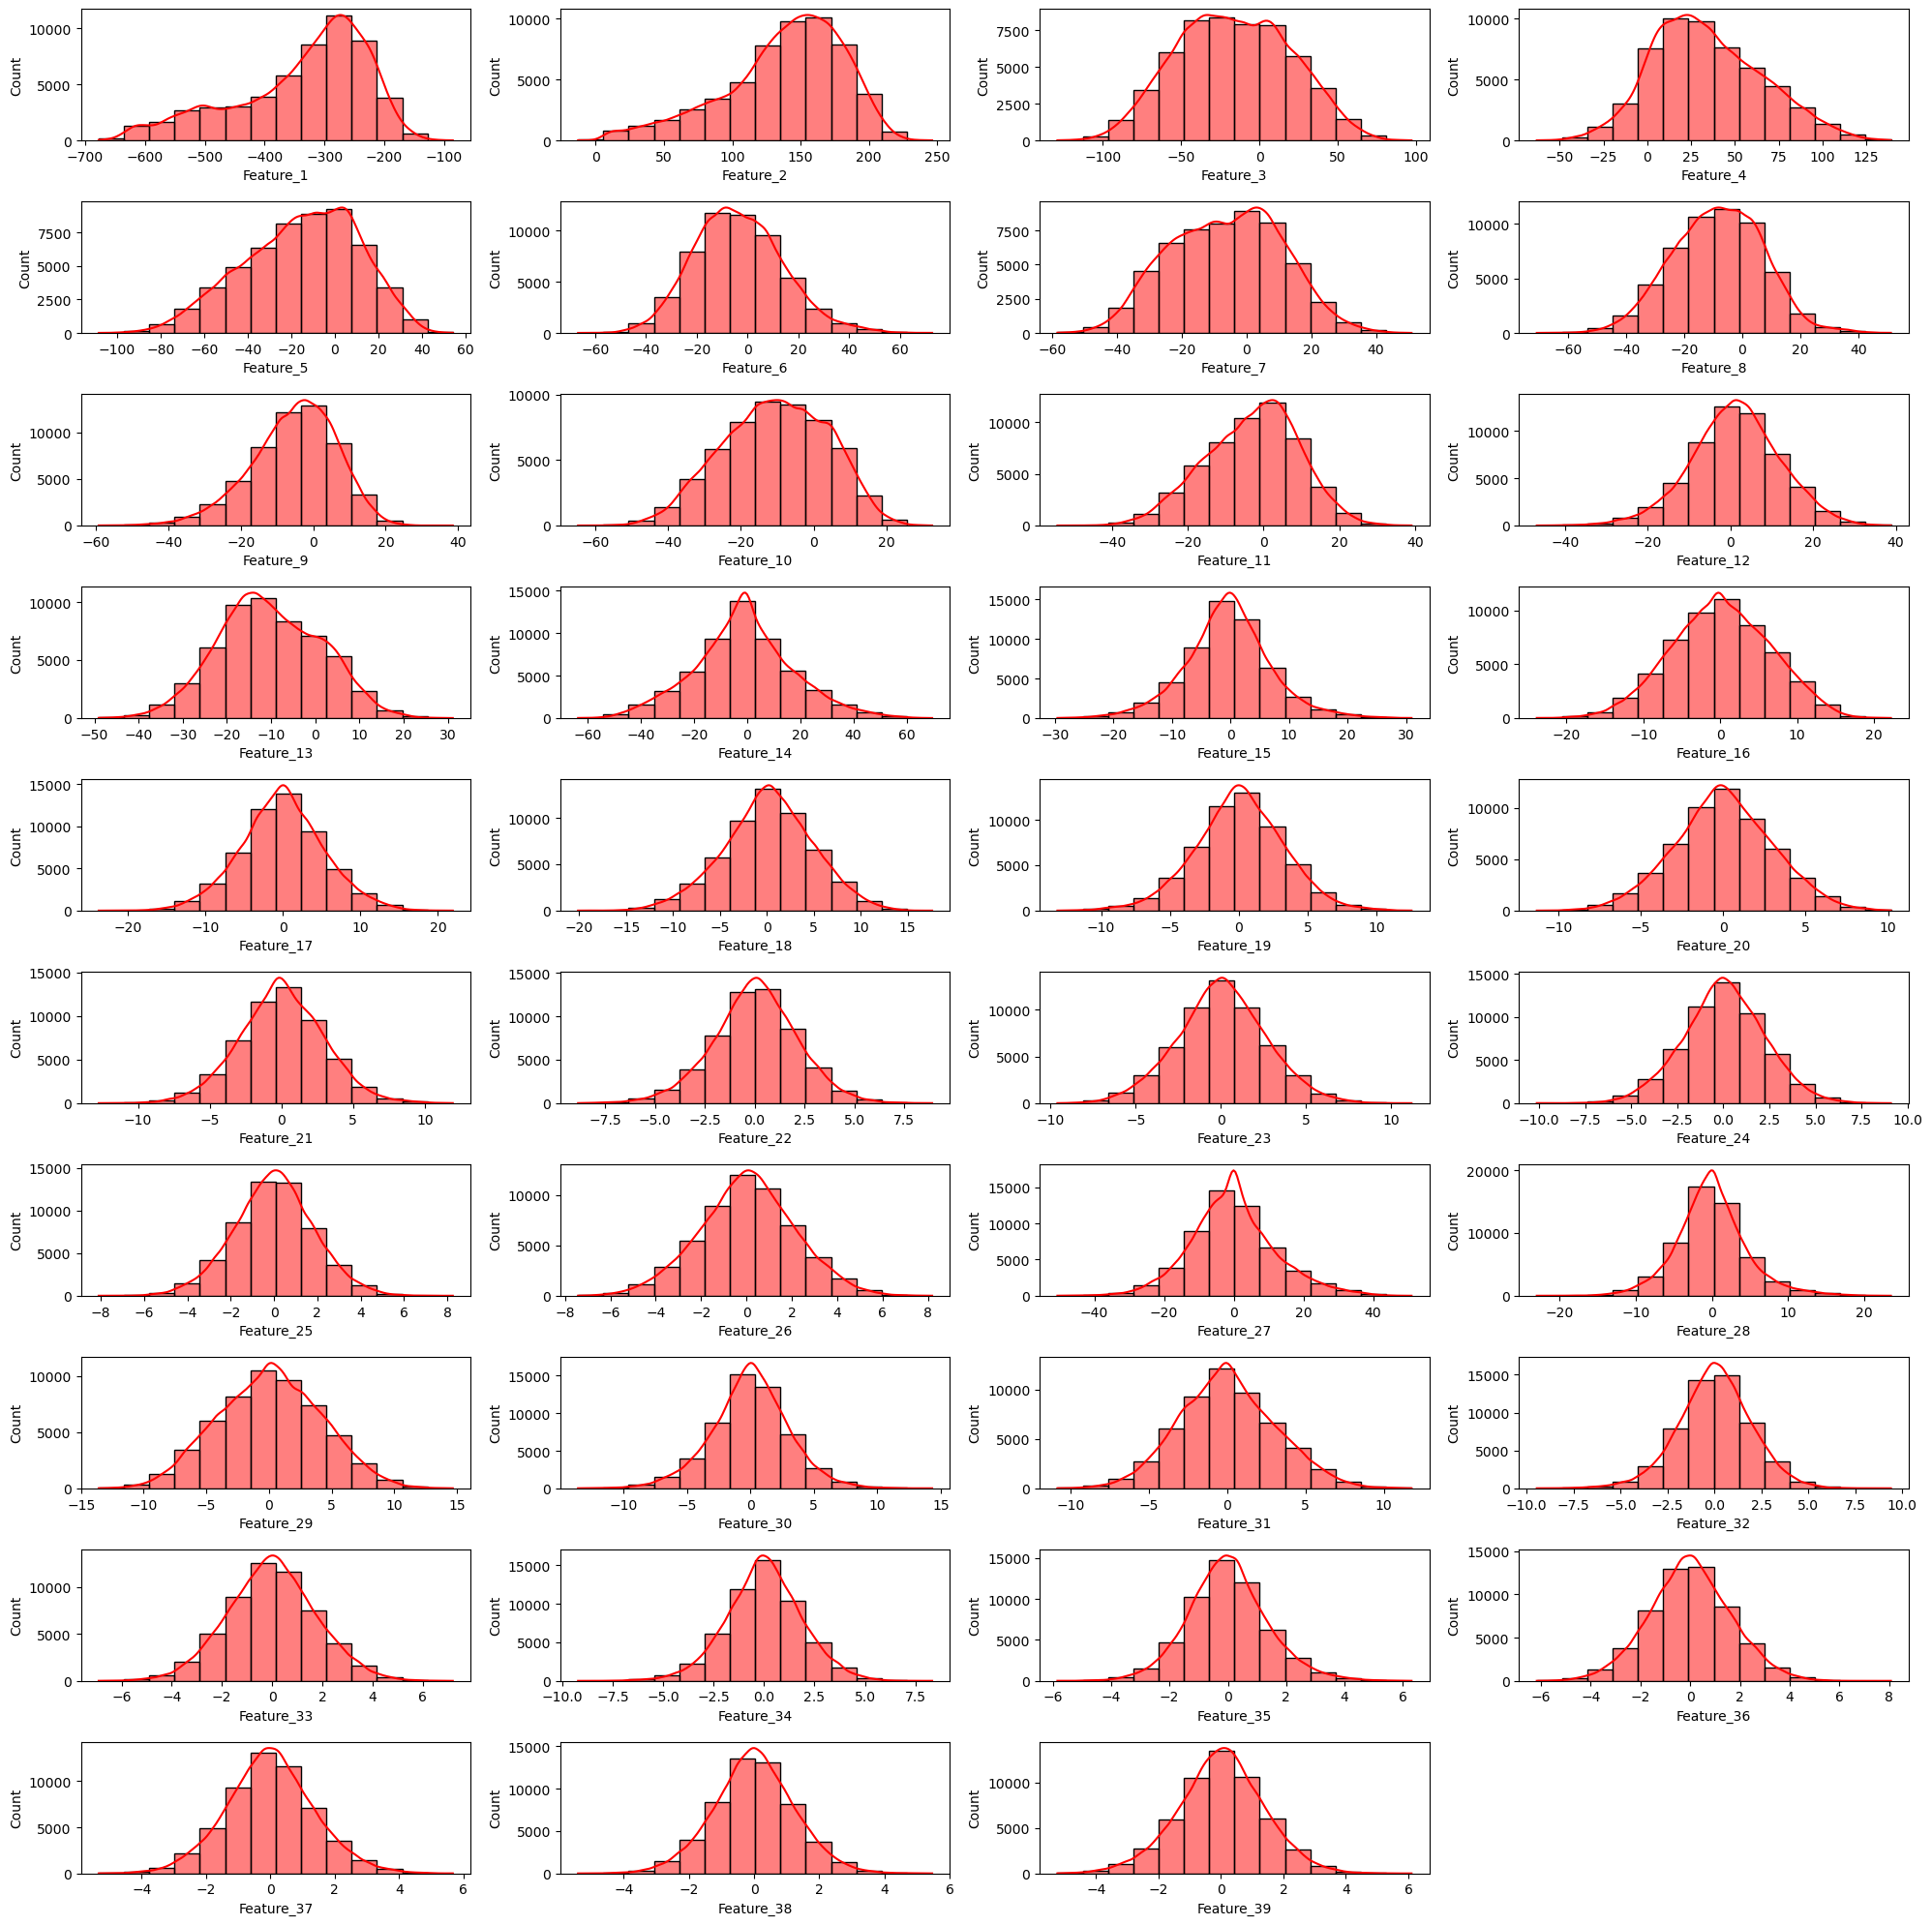

Hi


In [16]:
import warnings

# Filter out FutureWarning related to 'use_inf_as_na'
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version")

# Plot distribution of numerical attributes
cont_df = speech_df.iloc[:, 1:40]  # Select numerical attributes from 1 to 39

# Plot distribution of numerical attributes
plt.figure(figsize=(20,20))
for i in range(1, 40):
    plt.subplot(10, 4, i)
    with pd.option_context('mode.use_inf_as_na', True):  # Suppress FutureWarning
        sns.histplot(cont_df.iloc[:, i-1], bins=14, kde=True, kde_kws={'bw_method': 0.1}, color="r")

# Show the plot
plt.tight_layout()
plt.show()

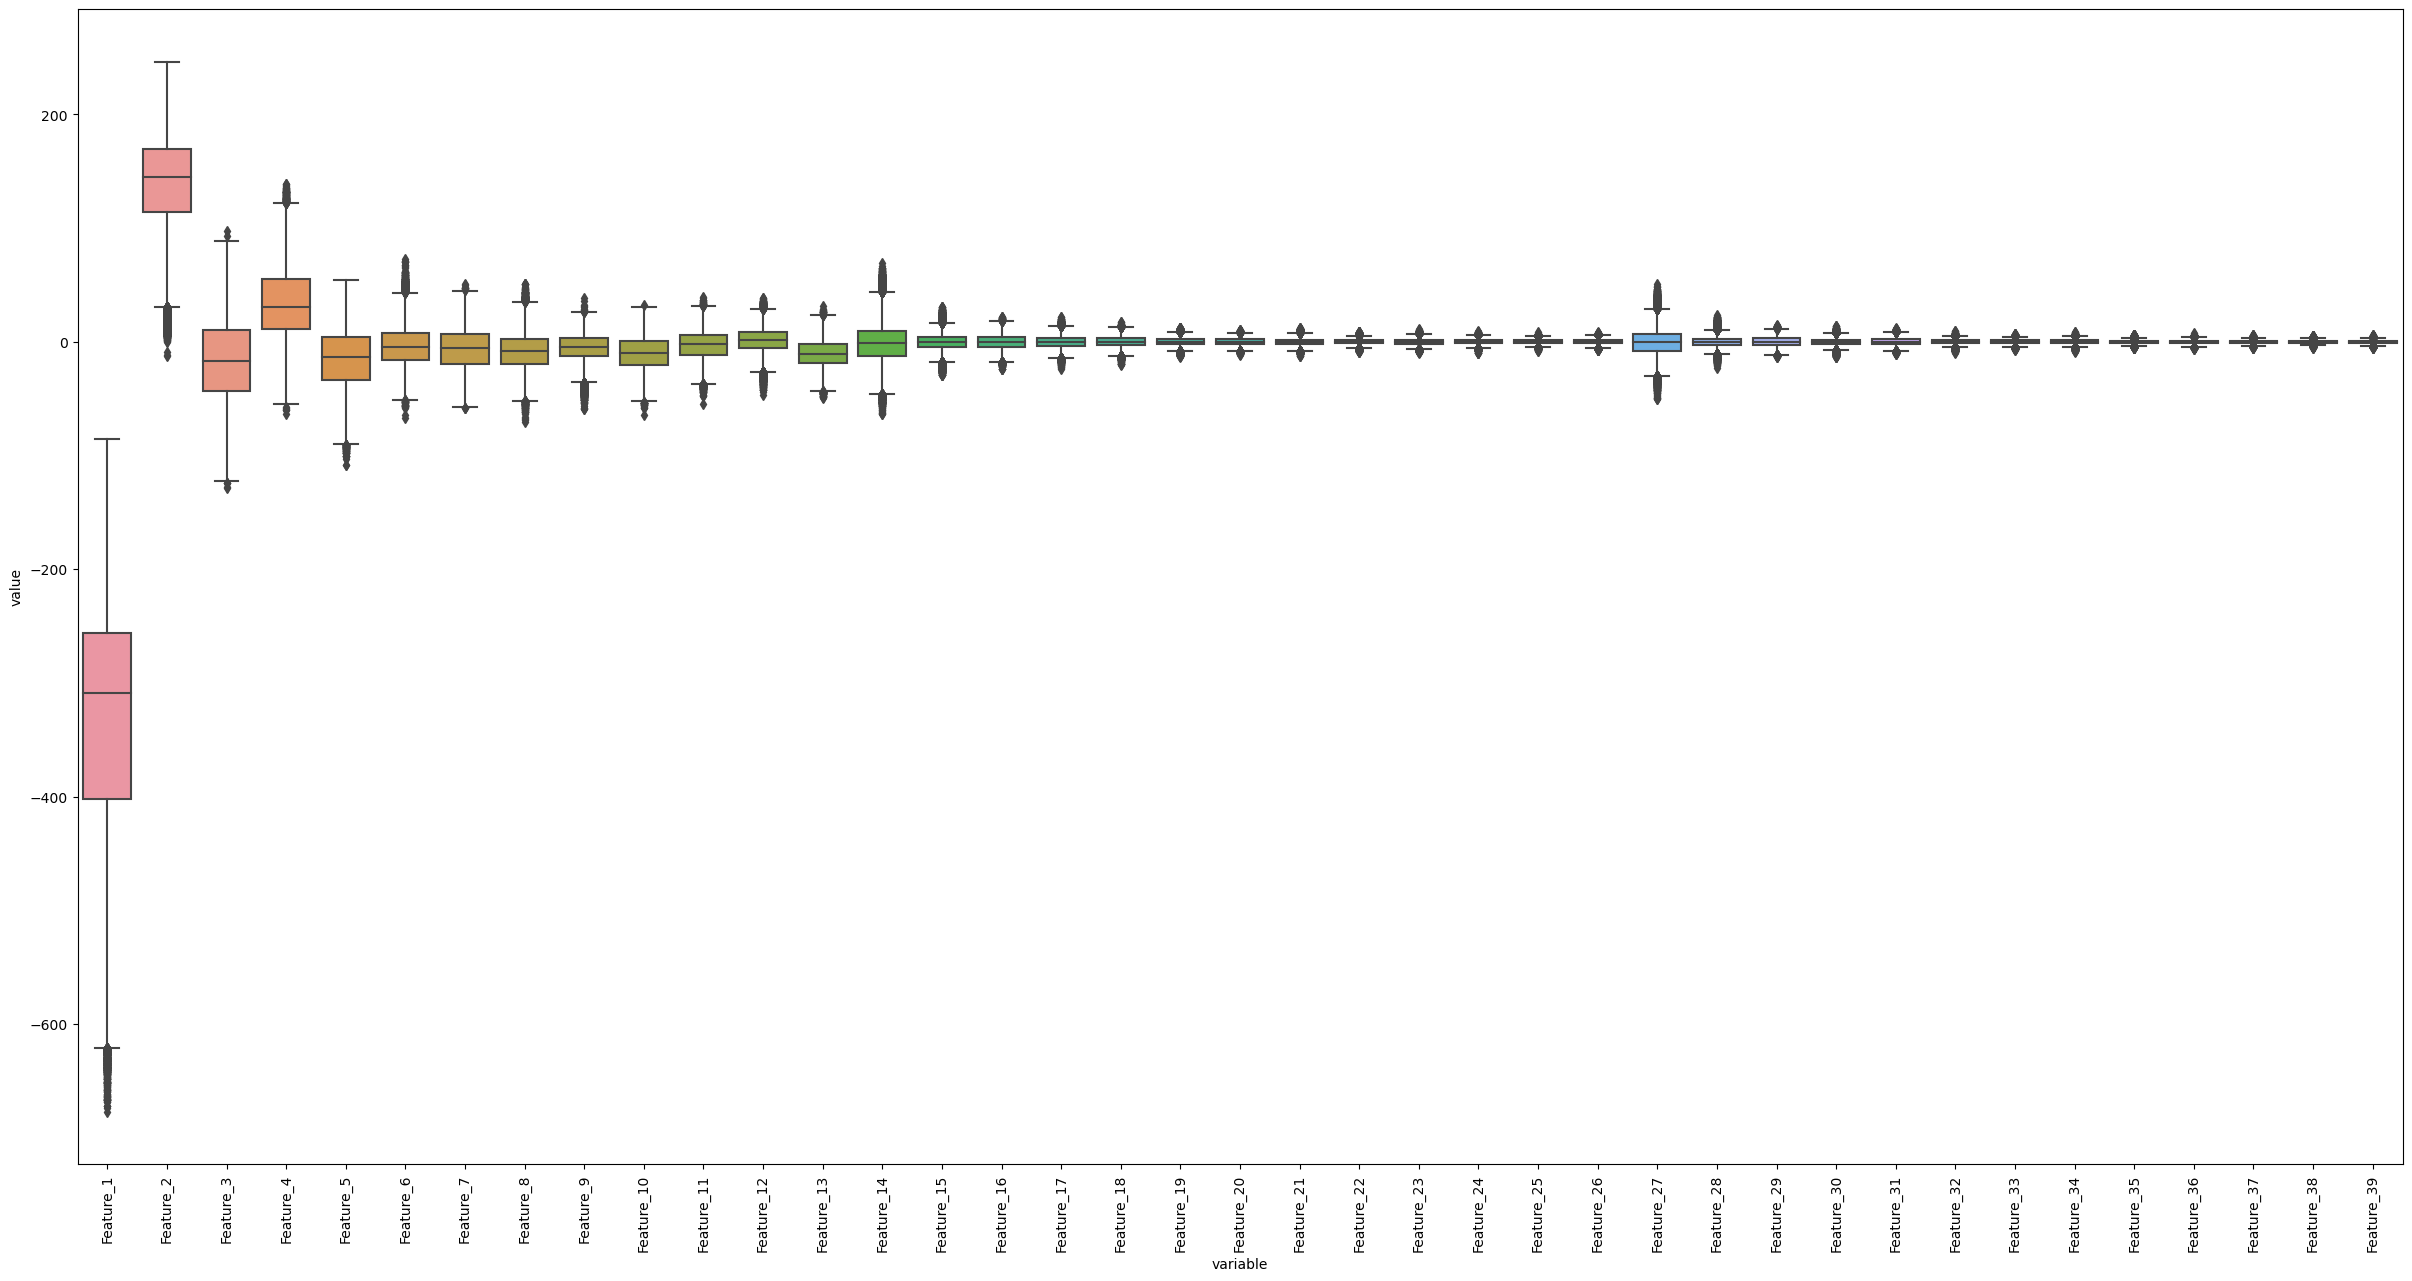

In [17]:
# display boxlots
plt.figure(figsize=(30,15))
sns.boxplot(x="variable", y="value", data=pd.melt(cont_df))
plt.xticks(rotation=90)
plt.show()

In [18]:
# find the IQR
q1 = speech_df.iloc[:, 1:40].quantile(.25)
q3 = speech_df.iloc[:, 1:40].quantile(.75)
IQR = q3-q1

outliers_df = np.logical_or((speech_df.iloc[:, 1:40] < (q1 - 1.5 * IQR)), (speech_df.iloc[:, 1:40] > (q3 + 1.5 * IQR))) 

outlier_list=[]
total_outlier=[]
for col in list(outliers_df.columns):
    try:
        total_outlier.append(outliers_df[col].value_counts()[True])
        outlier_list.append((outliers_df[col].value_counts()[True] / outliers_df[col].value_counts().sum()) * 100)
    except:
        outlier_list.append(0)
        total_outlier.append(0)
        
outlier_list

outlier_df=pd.DataFrame(zip(list(outliers_df.columns), total_outlier, outlier_list), columns=['name of the column', 'total', 'outlier(%)'])

#see totally how many outliers in cont features
outlier_df.set_index('name of the column', inplace=True)
#del outlier_df.index.name
outlier_df


,total,outlier(%)
name of the column,,
Feature_1,527,0.966529
Feature_2,1187,2.176983
Feature_3,7,0.012838
Feature_4,134,0.245759
Feature_5,72,0.132050
Feature_6,504,0.924347
Feature_7,14,0.025676
Feature_8,283,0.519028
Feature_9,605,1.109583


In [19]:
df_cont=speech_df.iloc[:, 1:40]
out_nan_df=df_cont[~outliers_df]
out_nan_df

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39
0,-457.84314,185.443360,35.781960,-16.938108,-7.395579,-8.949813,-9.582459,5.201546,4.738354,-9.909861,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
1,-428.55040,189.458680,17.123732,-12.962234,-0.573131,-2.881281,-8.458666,-0.055087,5.620351,-8.810675,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
2,-367.49720,194.504180,-13.056679,-4.157114,-22.554285,-19.575530,-3.851059,-3.728880,4.788766,-6.669346,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
3,-280.22574,208.563050,-31.201574,7.831125,-62.149563,-24.098580,7.857093,5.876415,9.197849,-15.027214,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
4,-242.70015,202.111220,-51.431137,1.769407,-80.866165,-15.219257,14.262138,7.462859,5.481049,-17.298094,...,-1.067393,6.170832,1.998502,-1.860367,-0.275360,-0.401168,1.105412,0.344703,0.088208,-1.831671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54520,-496.33353,76.228355,46.272907,28.923180,30.213268,33.949245,27.926050,17.566849,12.813047,13.486197,...,0.347201,0.042848,-0.291840,-0.563030,-0.607714,-0.547277,-0.497809,-0.313029,0.078526,0.424263
54521,-495.10593,76.093300,43.534150,27.141396,31.957884,37.418670,30.280120,18.915504,14.630953,14.950905,...,0.347201,0.042848,-0.291840,-0.563030,-0.607714,-0.547277,-0.497809,-0.313029,0.078526,0.424263
54522,-497.29434,73.188590,40.630608,22.983387,25.274796,28.812353,22.449840,14.136463,12.427485,13.365522,...,0.347201,0.042848,-0.291840,-0.563030,-0.607714,-0.547277,-0.497809,-0.313029,0.078526,0.424263
54523,-497.55518,70.764220,36.200005,20.862423,25.795094,27.560830,17.695229,8.747379,8.973435,12.147730,...,0.347201,0.042848,-0.291840,-0.563030,-0.607714,-0.547277,-0.497809,-0.313029,0.078526,0.424263


# Corelation between Languages


In [23]:
relative_path_tamil = r"Dataset\Language-Recognition-VAD-MFCC\Tamil-Train.csv"
relative_path_telugu = r"Dataset\Language-Recognition-VAD-MFCC\Telugu-Train.csv"
relative_path_gujrati = r"Dataset\Language-Recognition-VAD-MFCC\Gujrati-Train.csv"
# Load the two CSV files into pandas DataFrames, ignoring the first column

tamil_df = pd.read_csv(os.path.join(parent_dir, relative_path_tamil), index_col=0)
telugu_df = pd.read_csv(os.path.join(parent_dir, relative_path_telugu), index_col=0)
gujrati_df = pd.read_csv(os.path.join(parent_dir, relative_path_gujrati), index_col=0)

tamil_df = tamil_df.iloc[:20000]
telugu_df = telugu_df.iloc[:20000]
gujrati_df = gujrati_df.iloc[:20000]
# Calculate the correlation between each row of tamil_df and all rows of telugu_df

# Calculate the correlation between tamil_df and telugu_df using NumPy
correlation_values_te_ta = np.dot(tamil_df, telugu_df.T) / (np.linalg.norm(tamil_df, axis=1)[:, np.newaxis] * np.linalg.norm(telugu_df, axis=1))
correlation_values_te_gu = np.dot(gujrati_df, telugu_df.T) / (np.linalg.norm(gujrati_df, axis=1)[:, np.newaxis] * np.linalg.norm(telugu_df, axis=1))
correlation_values_gu_ta = np.dot(tamil_df, gujrati_df.T) / (np.linalg.norm(tamil_df, axis=1)[:, np.newaxis] * np.linalg.norm(gujrati_df, axis=1))

print("Average correlation between the Tamil and Telugu datasets:", np.mean(correlation_values_te_ta))
print("Average correlation between the Telugu and Gujarati datasets:", np.mean(correlation_values_te_gu))
print("Average correlation between the Gujrati and Tamil datasets:", np.mean(correlation_values_gu_ta))

Average correlation between the Tamil and Telugu datasets: 0.9294406490987329
Average correlation between the Telugu and Gujarati datasets: 0.9190860840228194
Average correlation between the Gujrati and Tamil datasets: 0.9073983440857092


### Average correlation between the Ta - Te two datasets for whole dataset: 0.9298581124634885
### Average correlation between the Gu - Te two datasets for whole dataset: 0.9187691195725824
### Average correlation between the Gu - Ta two datasets for whole dataset: 0.9071283846904906